In [105]:
from data_utils import load_control_experimental_MNIST, load_test_MNIST
from models import MnistNet
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt

colors = ['black','#377eb8', '#ff7f00', '#4daf4a',
              '#984ea3', '#a65628', '#f781bf',
              '#999999', '#e41a1c', '#dede00']
markers = [ 'h', '*', '<', 'o', 's', 'v', 'D' ]

In [2]:
sp_val = 0.1
test_spurious_values = [-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2]
rng_state = 42

In [3]:
control, experimental = load_control_experimental_MNIST(spurious_value=sp_val, rng_state=rng_state)

In [71]:
lr = 0.1
epochs = 1000 # instead of the original 50

In [5]:
def mean_accuracy(logits, y):
    preds = (logits > 0.).float()
    return ((preds - y).abs() < 1e-2).float().mean().item()

In [87]:
def fit(model, optim, criterion, train_set, clip=None, epochs=50):
    model.train()

    for i in tqdm(range(epochs)):
        optim.zero_grad()
        logits = model(train_set['images'])
        loss = criterion(logits, train_set['labels'])
        loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optim.step()

def eval(model, dataset):
    model.eval()
    logits = model(dataset['images'])
    acc = mean_accuracy(logits, dataset['labels'])
    return acc

In [73]:
def accuracies_on_test(model, spurious_values, spurious_correlation=0.5):
    accs = []
    for sp_val in spurious_values:
        test = load_test_MNIST(spurious_correlation=spurious_correlation, spurious_value=sp_val)
        accs.append(eval(model, test))
    return accs

In [88]:
def train_model_on(data, epochs, weight_decay=0, clip=None, name='model.pt'):
    criterion = torch.nn.BCEWithLogitsLoss()
    model = MnistNet(n_channels=2)
    optim = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    fit(model, optim, criterion, data, clip=clip, epochs=epochs)
    # save model just in case
    print("Save model to 'models/%s'" % name)
    torch.save(model.state_dict(), 'models/%s' % name)
    return model

In [63]:
LOAD_SAVED_MODEL = True

### Model trained on control dataset

In [126]:
control_accuracies = []
for k in range(5):
    if LOAD_SAVED_MODEL:
        model = MnistNet(n_channels=2)
        model.load_state_dict(torch.load('models/control_%d.pt' % k))
    else:
        model = train_model_on(control, epochs=epochs, name='control_%d.pt' % k)
    control_accuracies.append(accuracies_on_test(model, test_spurious_values))

### Model trained on experimental dataset

In [127]:
exp_accuracies = []
exp_accuracies_sp1 = []
exp_accuracies_sp0 = []
for k in range(5):
    if LOAD_SAVED_MODEL:
        model = MnistNet(n_channels=2)
        model.load_state_dict(torch.load('models/experimental_%d.pt' % k))
    else:
        model = train_model_on(experimental, epochs=epochs, name='experimental_%d.pt' % k)
    exp_accuracies.append(accuracies_on_test(model, test_spurious_values))
    exp_accuracies_sp1.append(accuracies_on_test(model, test_spurious_values, spurious_correlation=1.0))
    exp_accuracies_sp0.append(accuracies_on_test(model, test_spurious_values, spurious_correlation=0.0))

### Plot

In [128]:
control_accuracies = np.array(control_accuracies).transpose()
exp_accuracies = np.array(exp_accuracies).transpose()
exp_accuracies_sp1 = np.array(exp_accuracies_sp1).transpose()
exp_accuracies_sp0 = np.array(exp_accuracies_sp0).transpose()

y_con = [np.mean(y) for y in control_accuracies]
y_con_std = [np.std(y) for y in control_accuracies]
y_exp = [np.mean(y) for y in exp_accuracies]
y_exp_std = [np.std(y) for y in exp_accuracies]
y_exp_sp1 = [np.mean(y) for y in exp_accuracies_sp1]
y_exp_std_sp1 = [np.std(y) for y in exp_accuracies_sp1]
y_exp_sp0 = [np.mean(y) for y in exp_accuracies_sp0]
y_exp_std_sp0 = [np.std(y) for y in exp_accuracies_sp0]

<Figure size 360x360 with 0 Axes>

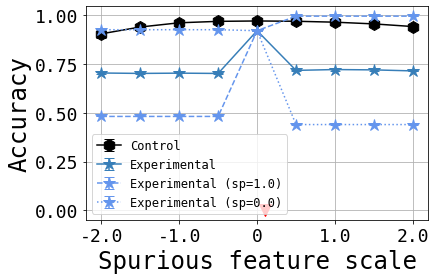

In [149]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Spurious feature scale',fontsize=24)
ax.set_ylabel(r'Accuracy',fontsize=24)
ax.errorbar(x=test_spurious_values, y=y_con, yerr=y_con_std, marker=markers[0], color=colors[0], 
            capsize=5,markersize=12, label='Control')
ax.errorbar(x=test_spurious_values, y=y_exp, yerr=y_exp_std, marker=markers[1], color=colors[1], 
            capsize=5,markersize=12, label='Experimental')
ax.errorbar(x=test_spurious_values, y=y_exp_sp1, yerr=y_exp_std_sp1, marker=markers[1], color='cornflowerblue', 
            capsize=5,markersize=12, label='Experimental (sp=1.0)', linestyle='dashed')
ax.errorbar(x=test_spurious_values, y=y_exp_sp0, yerr=y_exp_std_sp0, marker=markers[1], color='cornflowerblue', 
            capsize=5,markersize=12, label='Experimental (sp=0.0)', linestyle='dotted')
ax.plot([0.1], [0.001], marker='v', color='red', markersize=12)
ax.grid()
plt.tight_layout()
plt.xticks([-2.0, -1.0, 0, 1.0, 2.0], ['-2.0', '-1.0', '0', '1.0', '2.0'])
plt.legend(prop={'size': 12})
plt.savefig(f'plots/mnist_statistical_skew.pdf')

In [68]:
np.save('results/mnist_statistical_skew_control.npy', control_accuracies)
np.save('results/mnist_statistical_skew_experimental.npy', exp_accuracies)

# With L2 weight decay

In [75]:
model = train_model_on(experimental, epochs=epochs, weight_decay=0.001, name='experimental_wd_0.001_%d.pt' % 0)

100%|██████████| 1000/1000 [3:46:28<00:00, 13.59s/it] 

Save model to 'models/experimental_wd_0.pt'


In [76]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)

[0.705299973487854,
 0.7067000269889832,
 0.7024999856948853,
 0.6984000205993652,
 0.9164000153541565,
 0.7152000069618225,
 0.7106999754905701,
 0.7192000150680542,
 0.7110999822616577]

In [77]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=1)

[0.4805000126361847,
 0.4805000126361847,
 0.4805000126361847,
 0.4805000126361847,
 0.9164000153541565,
 0.9944000244140625,
 0.9944000244140625,
 0.9944000244140625,
 0.9944000244140625]

In [78]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0)

[0.921999990940094,
 0.921999990940094,
 0.921999990940094,
 0.921999990940094,
 0.9164000153541565,
 0.4359000027179718,
 0.4359000027179718,
 0.4359000027179718,
 0.4359000027179718]

In [79]:
model2 = train_model_on(experimental, epochs=epochs, weight_decay=0.01, name='experimental_wd_0.01_%d.pt' % 0)

100%|██████████| 1000/1000 [3:51:06<00:00, 13.87s/it] 

Save model to 'models/experimental_wd_0.01_0.pt'


In [80]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0.5)

[0.6783000230789185,
 0.6815999746322632,
 0.6732000112533569,
 0.6833999752998352,
 0.8722000122070312,
 0.6970000267028809,
 0.6952000260353088,
 0.6924999952316284,
 0.6958000063896179]

In [83]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=1)

[0.4812000095844269,
 0.4812000095844269,
 0.4812000095844269,
 0.4812000095844269,
 0.8722000122070312,
 0.9951000213623047,
 0.9951000213623047,
 0.9951000213623047,
 0.9951000213623047]

In [84]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0)

[0.8770999908447266,
 0.8770999908447266,
 0.8770999908447266,
 0.8770999908447266,
 0.8722000122070312,
 0.39100000262260437,
 0.39100000262260437,
 0.39100000262260437,
 0.39100000262260437]

In [81]:
model3 = train_model_on(experimental, epochs=epochs, weight_decay=0.1, name='experimental_wd_0.1_%d.pt' % 0)

100%|██████████| 1000/1000 [3:49:56<00:00, 13.80s/it] 

Save model to 'models/experimental_wd_0.1_0.pt'


In [82]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0.5)

[0.5331000089645386,
 0.5303000211715698,
 0.5332000255584717,
 0.535099983215332,
 0.5817999839782715,
 0.5443000197410583,
 0.5526999831199646,
 0.5482000112533569,
 0.5533999800682068]

In [85]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=1)

[0.48399999737739563,
 0.48399999737739563,
 0.48399999737739563,
 0.48399999737739563,
 0.5817999839782715,
 0.9979000091552734,
 0.9979000091552734,
 0.9979000091552734,
 0.9979000091552734]

In [86]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0)

[0.583899974822998,
 0.583899974822998,
 0.583899974822998,
 0.583899974822998,
 0.5817999839782715,
 0.09780000150203705,
 0.09780000150203705,
 0.09780000150203705,
 0.09780000150203705]

<Figure size 360x360 with 0 Axes>

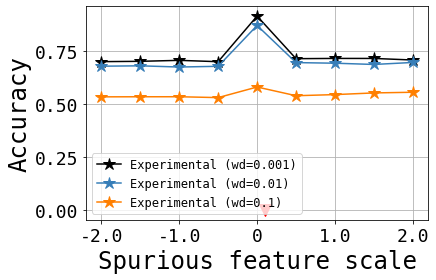

In [164]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Spurious feature scale',fontsize=24)
ax.set_ylabel(r'Accuracy',fontsize=24)
for i, wd in enumerate([0.001, 0.01, 0.1]):
    model = load_model(name='experimental_wd_%s_0.pt' % wd)
    accs = accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)
    ax.plot(test_spurious_values, accs, marker=markers[1], color=colors[i], 
                markersize=12, label='Experimental (wd=%s)'%wd)
ax.plot([0.1], [0.001], marker='v', color='red', markersize=12)
ax.grid()
plt.tight_layout()
plt.xticks([-2.0, -1.0, 0, 1.0, 2.0], ['-2.0', '-1.0', '0', '1.0', '2.0'])
plt.legend(prop={'size': 12})
plt.savefig(f'plots/mnist_wd_statistical_skew.pdf')

# With gradient clipping

In [150]:
def load_model(name):
    model = MnistNet(n_channels=2)
    model.load_state_dict(torch.load('models/%s' % name))
    return model

In [151]:
# model = train_model_on(experimental, epochs=epochs, clip=0.25, name='experimental_clip_0.25_%d.pt' % 0)
model = load_model(name='experimental_clip_0.25_%d.pt' % 0)

In [90]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)

[0.7002999782562256,
 0.699999988079071,
 0.6984000205993652,
 0.6890000104904175,
 0.9060999751091003,
 0.7127000093460083,
 0.711899995803833,
 0.7099000215530396,
 0.7142999768257141]

In [91]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=1.0)

[0.48249998688697815,
 0.48249998688697815,
 0.48249998688697815,
 0.48249998688697815,
 0.9060999751091003,
 0.996399998664856,
 0.996399998664856,
 0.996399998664856,
 0.996399998664856]

In [92]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0)

[0.9096999764442444,
 0.9096999764442444,
 0.9096999764442444,
 0.9096999764442444,
 0.9060999751091003,
 0.4235999882221222,
 0.4235999882221222,
 0.4235999882221222,
 0.4235999882221222]

In [152]:
# model2 = train_model_on(experimental, epochs=epochs, clip=0.1, name='experimental_clip_0.1_%d.pt' % 0)
model2 = load_model(name='experimental_clip_0.1_%d.pt' % 0)

In [94]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0.5)

[0.7056999802589417,
 0.7027000188827515,
 0.7038999795913696,
 0.7073000073432922,
 0.9161999821662903,
 0.7142999768257141,
 0.7142000198364258,
 0.714900016784668,
 0.7211999893188477]

In [95]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=1.0)

[0.48019999265670776,
 0.48019999265670776,
 0.48019999265670776,
 0.48019999265670776,
 0.9161999821662903,
 0.9940999746322632,
 0.9940999746322632,
 0.9940999746322632,
 0.9940999746322632]

In [96]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0)

[0.9221000075340271,
 0.9221000075340271,
 0.9221000075340271,
 0.9221000075340271,
 0.9161999821662903,
 0.4359999895095825,
 0.4359999895095825,
 0.4359999895095825,
 0.4359999895095825]

In [153]:
# model3 = train_model_on(experimental, epochs=epochs, clip=0.01, name='experimental_clip_0.01_%d.pt' % 0)
model3 = load_model(name='experimental_clip_0.01_%d.pt' % 0)

In [102]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0.5)

[0.586899995803833,
 0.5853000283241272,
 0.5878000259399414,
 0.5878000259399414,
 0.6922000050544739,
 0.6110000014305115,
 0.6121000051498413,
 0.5946000218391418,
 0.5992000102996826]

In [103]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=1.0)

[0.4715000092983246,
 0.4715000092983246,
 0.4715000092983246,
 0.4715000092983246,
 0.6922000050544739,
 0.9854000210762024,
 0.9854000210762024,
 0.9854000210762024,
 0.9854000210762024]

In [104]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0.0)

[0.7067999839782715,
 0.7067999839782715,
 0.7067999839782715,
 0.7067999839782715,
 0.6922000050544739,
 0.2206999957561493,
 0.2206999957561493,
 0.2206999957561493,
 0.2206999957561493]

<Figure size 360x360 with 0 Axes>

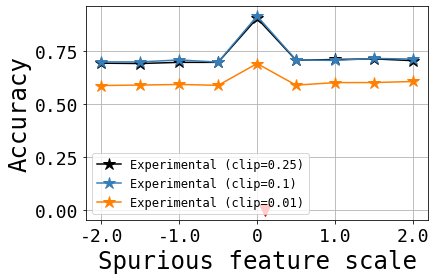

In [165]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Spurious feature scale',fontsize=24)
ax.set_ylabel(r'Accuracy',fontsize=24)
for i, clip in enumerate([0.25, 0.1, 0.01]):
    model = load_model(name='experimental_clip_%s_0.pt' % clip)
    accs = accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)
    ax.plot(test_spurious_values, accs, marker=markers[1], color=colors[i], 
                markersize=12, label='Experimental (clip=%s)'%clip)
ax.plot([0.1], [0.001], marker='v', color='red', markersize=12)
ax.grid()
plt.tight_layout()
plt.xticks([-2.0, -1.0, 0, 1.0, 2.0], ['-2.0', '-1.0', '0', '1.0', '2.0'])
plt.legend(prop={'size': 12})
plt.savefig(f'plots/mnist_clip_statistical_skew.pdf')

# Stochastic gradient descent

In [108]:
def fit_stochastic(model, optim, criterion, train_set, batch_size=64, clip=None, epochs=50):
    tensor_x = torch.Tensor(train_set['images'])
    tensor_y = torch.Tensor(train_set['labels'])
    my_dataset = TensorDataset(tensor_x, tensor_y)
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    
    model.train()

    for i in tqdm(range(epochs)):
        for (x,y) in my_dataloader:
            optim.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            optim.step()
            
def train_model_on_stochastic(data, epochs, weight_decay=0, batch_size=64, clip=None, name='model.pt'):
    criterion = torch.nn.BCEWithLogitsLoss()
    model = MnistNet(n_channels=2)
    optim = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    fit_stochastic(model, optim, criterion, data, clip=clip, epochs=epochs)
    # save model just in case
    print("Save model to 'models/%s'" % name)
    torch.save(model.state_dict(), 'models/%s' % name)
    return model

In [110]:
model = train_model_on_stochastic(experimental, epochs=epochs, batch_size=64, name='experimental_sto_64_%d.pt' % 0)

100%|██████████| 1000/1000 [8:40:01<00:00, 31.20s/it] 

Save model to 'models/experimental_sto_64_0.pt'


In [111]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)

[0.736299991607666,
 0.728600025177002,
 0.7386999726295471,
 0.8019000291824341,
 0.9847000241279602,
 0.9771999716758728,
 0.9398999810218811,
 0.8982999920845032,
 0.8747000098228455]

In [112]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=1.0)

[0.47929999232292175,
 0.47940000891685486,
 0.4828000068664551,
 0.617900013923645,
 0.9847000241279602,
 0.9779999852180481,
 0.9305999875068665,
 0.9243999719619751,
 0.9387000203132629]

In [113]:
accuracies_on_test(model, test_spurious_values, spurious_correlation=0.0)

[0.9915000200271606,
 0.9915000200271606,
 0.9915000200271606,
 0.9911999702453613,
 0.9847000241279602,
 0.977400004863739,
 0.9473000168800354,
 0.8773999810218811,
 0.8138999938964844]

In [114]:
model2 = train_model_on_stochastic(experimental, epochs=epochs, batch_size=512, name='experimental_sto_512_%d.pt' % 0)

100%|██████████| 1000/1000 [8:48:17<00:00, 31.70s/it] 

Save model to 'models/experimental_sto_512_0.pt'


In [115]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0.5)

[0.7439000010490417,
 0.7361999750137329,
 0.7577000260353088,
 0.8495000004768372,
 0.9853000044822693,
 0.9771000146865845,
 0.9319000244140625,
 0.8479999899864197,
 0.7860999703407288]

In [116]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=1.0)

[0.483599990606308,
 0.4925000071525574,
 0.5286999940872192,
 0.70169997215271,
 0.9853000044822693,
 0.9847000241279602,
 0.9886000156402588,
 0.9912999868392944,
 0.992900013923645]

In [117]:
accuracies_on_test(model2, test_spurious_values, spurious_correlation=0.0)

[0.9919999837875366,
 0.9919000267982483,
 0.9918000102043152,
 0.9912999868392944,
 0.9853000044822693,
 0.9704999923706055,
 0.8756999969482422,
 0.7085999846458435,
 0.5794000029563904]

In [118]:
model3 = train_model_on_stochastic(experimental, epochs=epochs, batch_size=4096, name='experimental_sto_4096_%d.pt' % 0)

100%|██████████| 1000/1000 [8:16:15<00:00, 29.78s/it] 

Save model to 'models/experimental_sto_4096_0.pt'


In [119]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0.5)

[0.7347999811172485,
 0.7450000047683716,
 0.7372000217437744,
 0.8141000270843506,
 0.9854000210762024,
 0.9804999828338623,
 0.9527999758720398,
 0.9257000088691711,
 0.9068999886512756]

In [120]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=1.0)

[0.4788999855518341,
 0.4788999855518341,
 0.4837000072002411,
 0.6370000243186951,
 0.9854000210762024,
 0.9811999797821045,
 0.9578999876976013,
 0.9354000091552734,
 0.9301000237464905]

In [121]:
accuracies_on_test(model3, test_spurious_values, spurious_correlation=0.0)

[0.9926000237464905,
 0.9926000237464905,
 0.9926000237464905,
 0.9922999739646912,
 0.9854000210762024,
 0.9782999753952026,
 0.949999988079071,
 0.911899983882904,
 0.8766999840736389]

<Figure size 360x360 with 0 Axes>

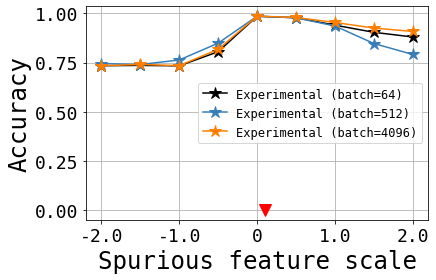

In [166]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Spurious feature scale',fontsize=24)
ax.set_ylabel(r'Accuracy',fontsize=24)
for i, bs in enumerate([64, 512, 4096]):
    model = load_model(name='experimental_sto_%s_0.pt' % bs)
    accs = accuracies_on_test(model, test_spurious_values, spurious_correlation=0.5)
    ax.plot(test_spurious_values, accs, marker=markers[1], color=colors[i], 
                markersize=12, label='Experimental (batch=%s)'%bs)
ax.plot([0.1], [0.001], marker='v', color='red', markersize=12)
ax.grid()
plt.tight_layout()
plt.xticks([-2.0, -1.0, 0, 1.0, 2.0], ['-2.0', '-1.0', '0', '1.0', '2.0'])
plt.legend(prop={'size': 12})
plt.savefig(f'plots/mnist_sto_statistical_skew.pdf')